Setting up the dataset and making sure it is cleaned up well

In [6]:
# Import statements

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os

In [47]:
# Remove NaN functions

# Given a dataframe, removes all rows that have NaN data.
def remove_nan_rows(df):
    return df.dropna(axis = 0)

# Given a dataframe, replace all NaNs with a summary statistic of your choice.
def replace_nan_with_mean(df):
    df_copy = df.copy()
    for col in df_copy.columns:
        if df_copy[col].isna().any():
            df_copy[col].fillna(df_copy[col].mean(), inplace=True)
    return df_copy

# Given a column of categorical data and an exhaustive list of labels, returns a one-hot encoding.
def one_hot_encode(name):
    column = df[name]
    labels = column.unique()
    return pd.get_dummies(column, prefix=column.name).reindex(columns=[f"{column.name}_{label}" for label in labels], fill_value=0)

def label_encode(column):
    # Get the unique labels in the column
    labels = column.unique()
    
    # Create a dictionary to map each label to a unique number
    label_dict = {label: idx for idx, label in enumerate(labels)}
    
    # Map the column values to the corresponding numbers
    return column.map(label_dict)


In [50]:
# Import Data set and clean 

df = pd.read_csv('../Crime_Data_from_2020_to_Present.csv')
# Replace NaN values with mean
df = df.drop(columns=['Date Rptd', 'DATE OCC', 'Status', 'Status Desc', 'Crm Cd 1', 'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4','Weapon Used Cd', 'Weapon Desc'])
df = df[df['Vict Age'] != 0]
df = remove_nan_rows(df)
print(df.shape)

# Calculate the median for LAT and LON excluding 0s
lat_median = df[df['LAT'] != 0]['LAT'].median()
lon_median = df[df['LON'] != 0]['LON'].median()
# Fill LAT and LON where they are 0
df.loc[(df['LAT'] == 0), 'LAT'] = lat_median
df.loc[(df['LON'] == 0), 'LON'] = lon_median


categorical_columns = ["Cross Street", "LOCATION", "Premis Desc", "Vict Descent", "Vict Sex"]
for name in categorical_columns:
    df[name + '_encoded'] = label_encode(df[name])
print(df.columns)

df.head()




(114276, 18)
Index(['DR_NO', 'TIME OCC', 'AREA', 'AREA NAME', 'Rpt Dist No', 'Part 1-2',
       'Crm Cd', 'Crm Cd Desc', 'Mocodes', 'Vict Age', 'Vict Sex',
       'Vict Descent', 'Premis Cd', 'Premis Desc', 'LOCATION', 'Cross Street',
       'LAT', 'LON', 'Cross Street_encoded', 'LOCATION_encoded',
       'Premis Desc_encoded', 'Vict Descent_encoded', 'Vict Sex_encoded'],
      dtype='object')


,DR_NO,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,Mocodes,Vict Age,...,Premis Desc,LOCATION,Cross Street,LAT,LON,Cross Street_encoded,LOCATION_encoded,Premis Desc_encoded,Vict Descent_encoded,Vict Sex_encoded
19,200606074,1615,6,Hollywood,646,2,805,PIMPING,1300 1402,23,...,STREET,HOLLYWOOD,MC CADDEN,34.1016,-118.3370,0,0,0,0,0
46,201225656,2245,12,77th Street,1268,1,210,ROBBERY,0344 0305 0355,21,...,STREET,SAN PEDRO,85TH ST,33.9610,-118.2695,1,1,0,0,1
64,201210786,2035,12,77th Street,1259,1,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",1822 2024 0445 0411 1218 2033,26,...,ALLEY,74TH ST,AVALON,33.9730,-118.2652,2,2,1,1,0
67,200506268,1900,5,Harbor,511,1,440,THEFT PLAIN - PETTY ($950 & UNDER),0319 0344 0429 0448 0305,29,...,SIDEWALK,PACIFIC COAST,VERMONT,33.7926,-118.3043,3,3,2,2,0
69,200206940,1255,2,Rampart,216,1,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",1822 0202 1309 1310 0906 0302 1100 0430,28,...,STREET,BELLEVUE AV,CORONADO ST,34.0751,-118.2717,4,4,0,0,1


In [51]:
from sklearn.model_selection import train_test_split

# If dataset is large, we can use a subset
df = df.sample(n=10000, random_state=42)  # Use a random subset of 10,000 rows

# Split data into train, validation, and test sets (70% train, 15% validation, 15% test)
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Display the split sizes
print(f"Training Set: {len(train_df)}")
print(f"Validation Set: {len(valid_df)}")
print(f"Test Set: {len(test_df)}")

Training Set: 7000
Validation Set: 1500
Test Set: 1500


In [53]:
target_column = 'Cross Street_encoded'

# Extract features and target
X_train = train_df.drop(columns=[target_column])
y_train = train_df[target_column]
X_valid = valid_df.drop(columns=[target_column])
y_valid = valid_df[target_column]
X_test = test_df.drop(columns=[target_column])
y_test = test_df[target_column]

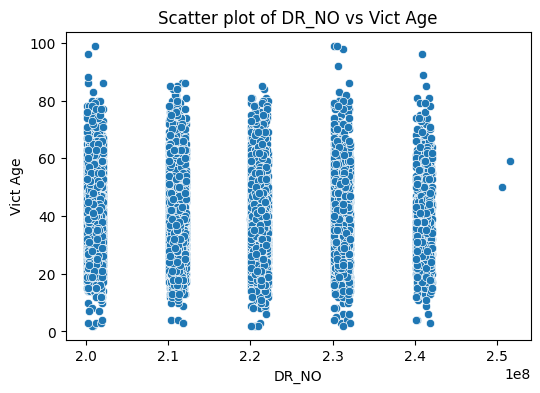

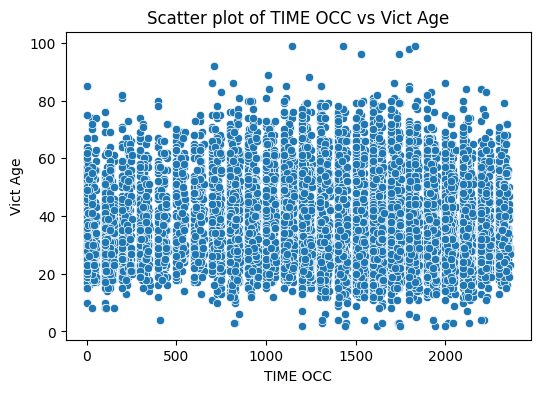

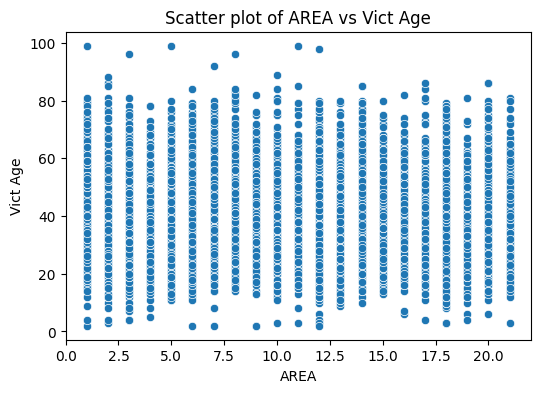

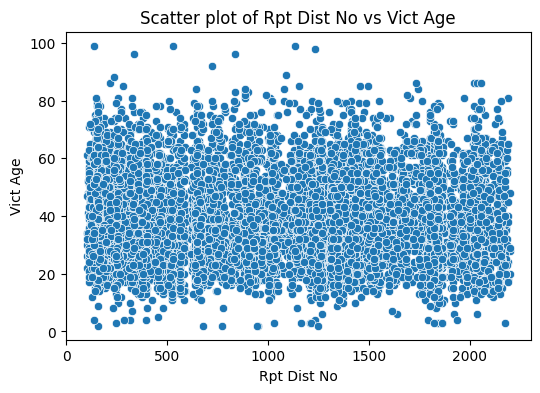

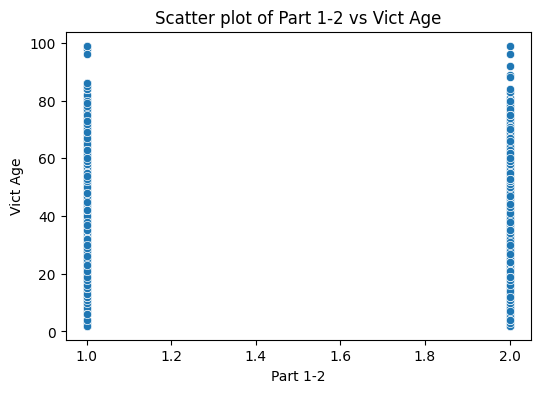

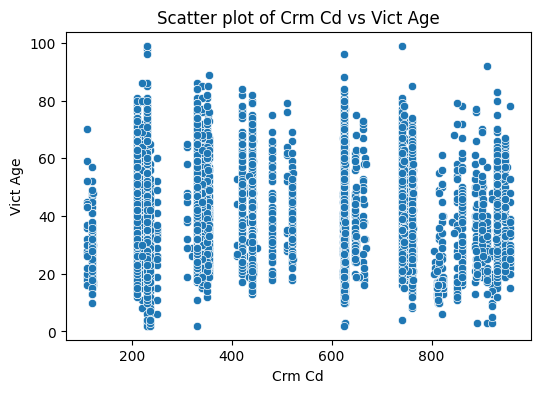

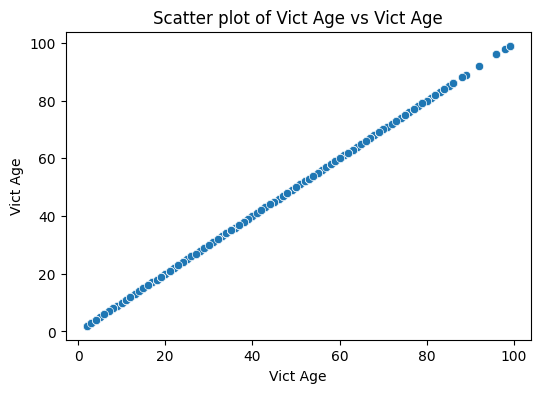

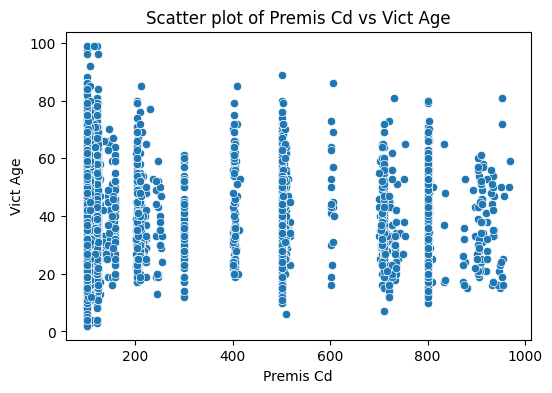

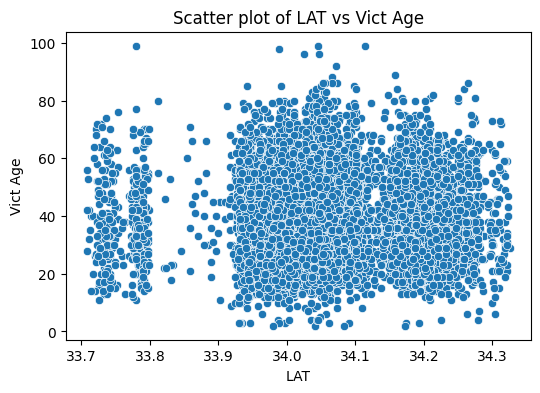

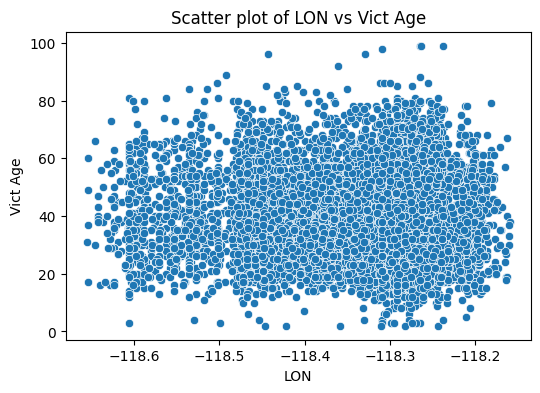

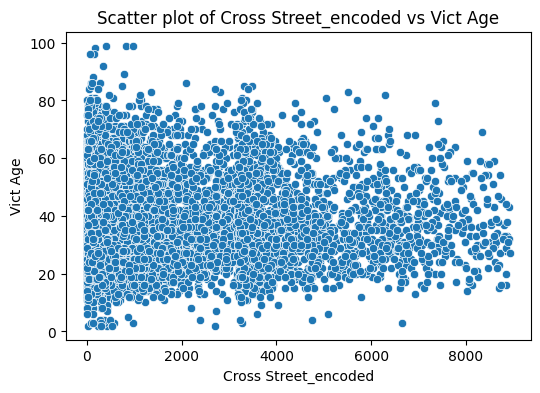

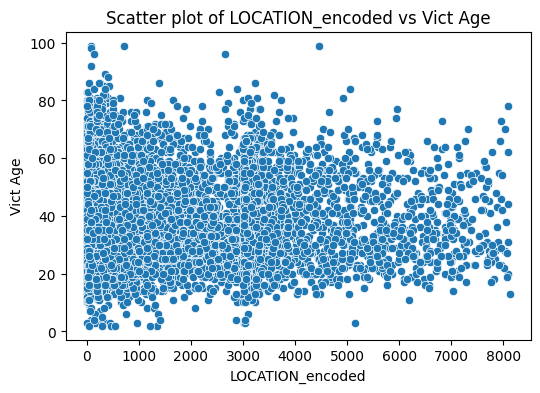

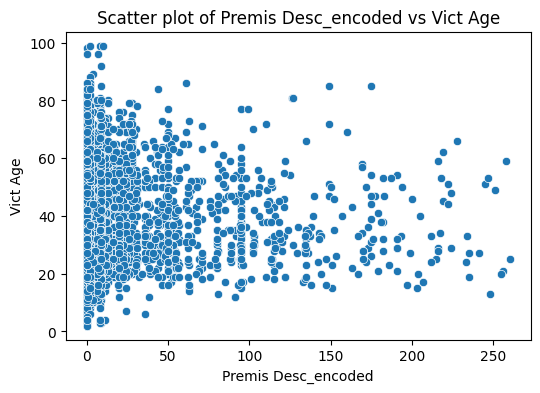

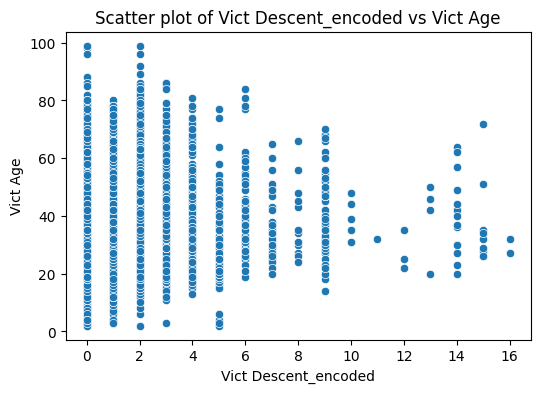

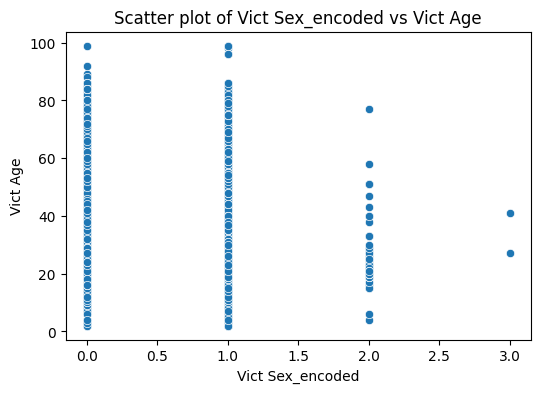

In [66]:
# Get features with highest correlation to target Rpt Dist to AREA, LAT to LON
target_column = 'Vict Age'
numeric_df = train_df.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()
high_corr_features = corr_matrix[target_column].abs().sort_values(ascending=False).index[1:4]  # Exclude the target itself

# Plot scatterplots
for feature in numeric_df:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=df[feature], y=df[target_column])
    plt.title(f'Scatter plot of {feature} vs {target_column}')
    plt.xlabel(feature)
    plt.ylabel(target_column)
    plt.show()

In [70]:
correlation_matrix = numeric_df.corr()
print(correlation_matrix)


                         DR_NO  TIME OCC      AREA  Rpt Dist No  Part 1-2  \
DR_NO                 1.000000  0.006427  0.076884     0.077528  0.008138   
TIME OCC              0.006427  1.000000  0.001594     0.002524 -0.005460   
AREA                  0.076884  0.001594  1.000000     0.999182  0.014998   
Rpt Dist No           0.077528  0.002524  0.999182     1.000000  0.014742   
Part 1-2              0.008138 -0.005460  0.014998     0.014742  1.000000   
Crm Cd                0.008105 -0.002536  0.003079     0.002728  0.819766   
Vict Age              0.008173 -0.020576  0.006977     0.006351  0.004421   
Premis Cd            -0.002402 -0.001969  0.006562     0.006593  0.052687   
LAT                   0.023582  0.005265  0.232888     0.232436  0.025609   
LON                  -0.015747 -0.004592 -0.405424    -0.406300 -0.054882   
Cross Street_encoded  0.117615  0.007802  0.232115     0.232931 -0.010493   
LOCATION_encoded      0.107765  0.022588  0.272064     0.271807 -0.030337   

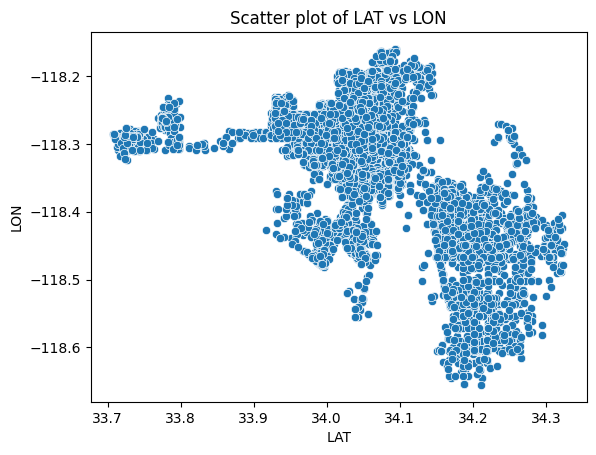

In [72]:
feature = "LAT"
target_column = "LON"
plt.title(f'Scatter plot of {feature} vs {target_column}')
plt.xlabel(feature)
plt.ylabel(target_column)
sns.scatterplot(x=df["LAT"], y=df["LON"])
plt.savefig(f'../ms3plots/lat_vs_lon.png')


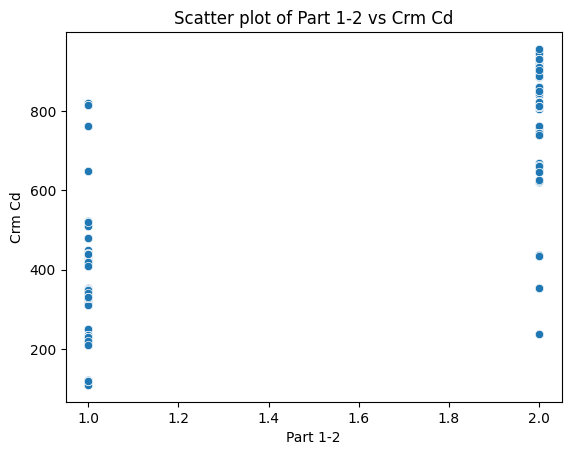

In [73]:
feature = "Part 1-2"
target_column = "Crm Cd"
plt.title(f'Scatter plot of {feature} vs {target_column}')
plt.xlabel(feature)
plt.ylabel(target_column)
sns.scatterplot(x=df[feature], y=df[target_column])
plt.savefig(f'../ms3plots/part_vs_crm.png')


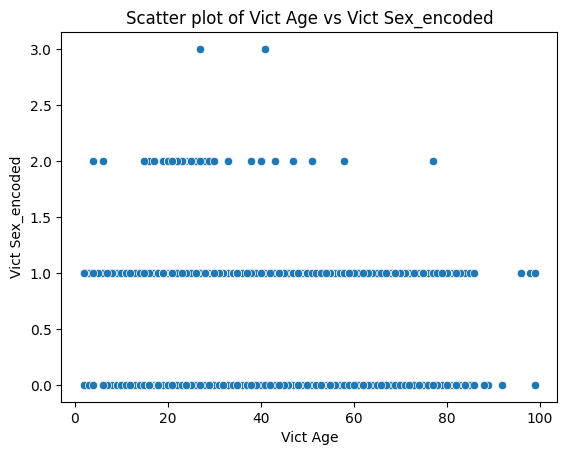

In [74]:
feature = "Vict Age"
target_column = "Vict Sex_encoded"
plt.title(f'Scatter plot of {feature} vs {target_column}')
plt.xlabel(feature)
plt.ylabel(target_column)
sns.scatterplot(x=df[feature], y=df[target_column])
plt.savefig(f'../ms3plots/age_vs_sex.png')


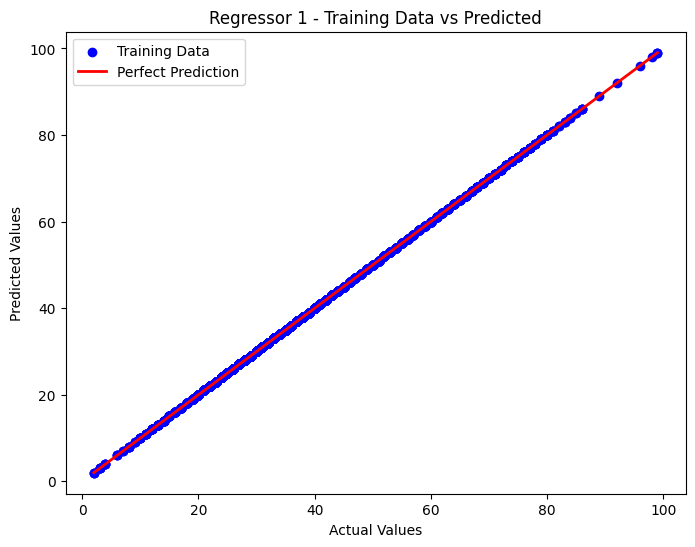

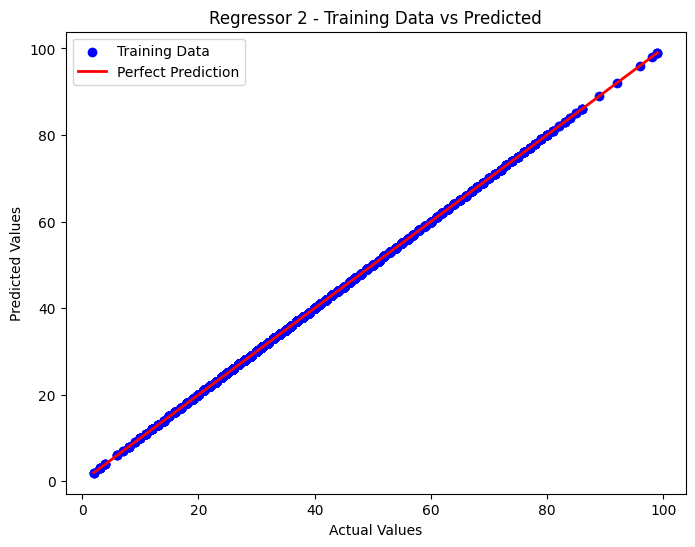

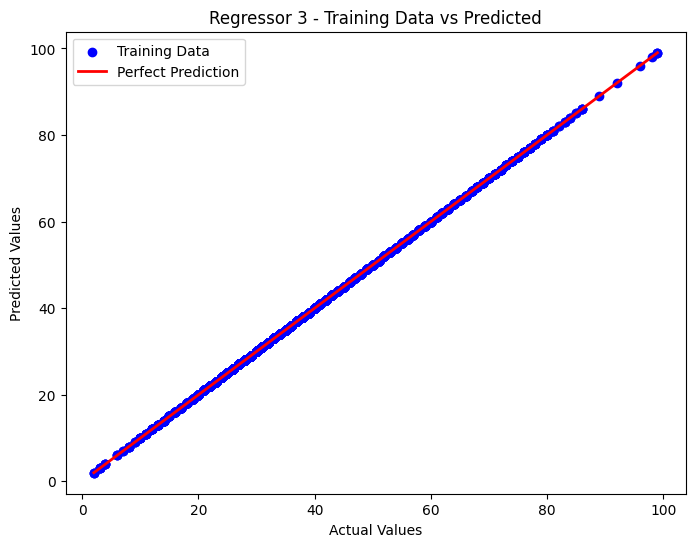

     Regressor  Training MSE  Validation MSE
0  Regressor 1  4.133410e-26    4.200139e-26
1  Regressor 2  4.133410e-26    4.200139e-26
2  Regressor 3  4.133410e-26    4.200139e-26
Test MSE of Best Model: 4.2060883724900594e-26


In [89]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

features_regressor_1 = ['Part 1-2', 'Crm Cd']
features_regressor_2 = ['LAT', 'LON']
features_regressor_3 = ['Vict Age', 'Vict Sex_encoded']

target_column = 'Vict Age' #We have little to no correlation so we are just playing around with data at this point :(

X = df[features_regressor_1 + features_regressor_2 + features_regressor_3]  # Combine all features
y = df[target_column]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

def train_evaluate_regressor(X_train, y_train, X_val, y_val, model_name) :
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)


    plt.figure(figsize=(8, 6))
    plt.scatter(y_train, y_train_pred, color='blue', label='Training Data')
    plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', lw=2, label='Perfect Prediction')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'{model_name} - Training Data vs Predicted')
    plt.legend()
    plt.savefig(f"../ms3plots/{model_name}_training_plot.png")
    plt.show()

    #mse
    train_mse = mean_squared_error(y_train, y_train_pred)
    val_mse = mean_squared_error(y_val, y_val_pred)
    return model, train_mse, val_mse


regressor_1, train_mse_1, val_mse_1 = train_evaluate_regressor(X_train, y_train, X_val, y_val, 'Regressor 1')
regressor_2, train_mse_2, val_mse_2 = train_evaluate_regressor(X_train, y_train, X_val, y_val, 'Regressor 2')
regressor_3, train_mse_3, val_mse_3 = train_evaluate_regressor(X_train, y_train, X_val, y_val, 'Regressor 3')
# Create a table of training and validation errors
error_table = pd.DataFrame({
    'Regressor': ['Regressor 1', 'Regressor 2', 'Regressor 3'],
    'Training MSE': [train_mse_1, train_mse_2, train_mse_3],
    'Validation MSE': [val_mse_1, val_mse_2, val_mse_3]
})



error_table = pd.DataFrame({
    'Regressor': ['Regressor 1', 'Regressor 2', 'Regressor 3'],
    'Training MSE': [train_mse_1, train_mse_2, train_mse_3],
    'Validation MSE': [val_mse_1, val_mse_2, val_mse_3]
})

print(error_table)

# picking a random model and testing the MSE
best_regressor_index = error_table['Validation MSE'].idxmin()
best_regressor_name = error_table['Regressor'][best_regressor_index]
best_regressor = [regressor_1, regressor_2, regressor_3]
best_model = best_regressor[best_regressor_index]


# Test the best model on the test set
y_test_pred = best_model.predict(X_test[['Part 1-2', 'Crm Cd', "LAT", "LON", "Vict Age", "Vict Sex_encoded"]])
test_mse = mean_squared_error(y_test, y_test_pred)

print(f"Test MSE of Best Model: {test_mse}")
